## CatBoost notebook

After preprocessing and feature engineering, we use Optuna to determine hyperparameters for our CatBoost model.  It produces a RMSLE of 0.05906, which is 1090/4318 in the Kaggle competition.  For explainability, we examine feature importance, residual plots, and SHAP values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
import optuna
from catboost import CatBoostRegressor, Pool
import shap

In [2]:
train = pd.read_csv("train_pp.csv")
test = pd.read_csv("test_pp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189,82,26,101,41.0,5.017280
1,0,64,163,60,8,85,39.7,3.555348
2,0,51,161,64,7,84,39.8,3.401197
3,1,20,192,90,25,105,40.7,4.948760
4,0,38,166,61,25,102,40.6,4.990433


Feature Engineering:

In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, and Body_Temp squared
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

Use Optuna for hyperparameter selection!

In [ ]:
X = add_feats(train, numerical_features)
y = train['Calories']

def objective(trial):
    
    params = {
        'iterations': 2000,
        'depth': trial.suggest_int('depth', 9, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, step=0.005),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-8, 1.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree","Depthwise","Lossguide"]),
        'task_type': 'GPU',
        'eval_metric': 'RMSE',
    }


    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X):
        X_train, X_val = X.loc[train_index], X.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]

        # Initialize the model with the suggested hyperparameters
        model = CatBoostRegressor(
            **params,
            loss_function='RMSE',
            random_state=724,
            verbose=0,
            early_stopping_rounds=40
        )
        
        # Create pool for validation to enable early stopping
        train_pool = Pool(X_train, y_train, cat_features=[0])
        val_pool = Pool(X_val, y_val, cat_features=[0])

        # Train and evaluate
        model.fit(train_pool, eval_set=val_pool, verbose=False, use_best_model=True)
        predictions = model.predict(X_val)
        # print("Stopped at:", model.get_best_iteration())
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error





if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='cb_early_stop', storage="sqlite:///catboost.db", load_if_exists=True)
    study.optimize(objective, n_trials=200, timeout=18000)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-21 17:20:12,729] Using an existing study with name 'cb_early_stop' instead of creating a new one.
[I 2025-06-21 17:20:49,207] Trial 195 finished with value: 0.059995765082036544 and parameters: {'depth': 12, 'learning_rate': 0.08, 'l2_leaf_reg': 0.00033325156906904906, 'bagging_temperature': 0.0003161225632965911, 'border_count': 182, 'grow_policy': 'SymmetricTree'}. Best is trial 192 with value: 0.059539294702456336.
[I 2025-06-21 17:22:33,239] Trial 196 finished with value: 0.05962618816573138 and parameters: {'depth': 12, 'learning_rate': 0.02, 'l2_leaf_reg': 0.00035053263654714656, 'bagging_temperature': 0.00021220166621701645, 'border_count': 187, 'grow_policy': 'SymmetricTree'}. Best is trial 192 with value: 0.059539294702456336.
[I 2025-06-21 17:23:51,971] Trial 197 finished with value: 0.059636866767103926 and parameters: {'depth': 12, 'learning_rate': 0.030000000000000002, 'l2_leaf_reg': 0.0002507167768559009, 'bagging_temperature': 0.00011045449431924622, 'border_c

Number of finished trials:  341
Best trial:
  Value: 0.05952698559201885
  Params: 
    depth: 12
    learning_rate: 0.015
    l2_leaf_reg: 0.00011954668586223026
    bagging_temperature: 4.475008023561076e-05
    border_count: 133
    grow_policy: SymmetricTree


Stopped at: 1676
Train prediction: 0.053670626593990814
Test prediction: 0.05953898263978798


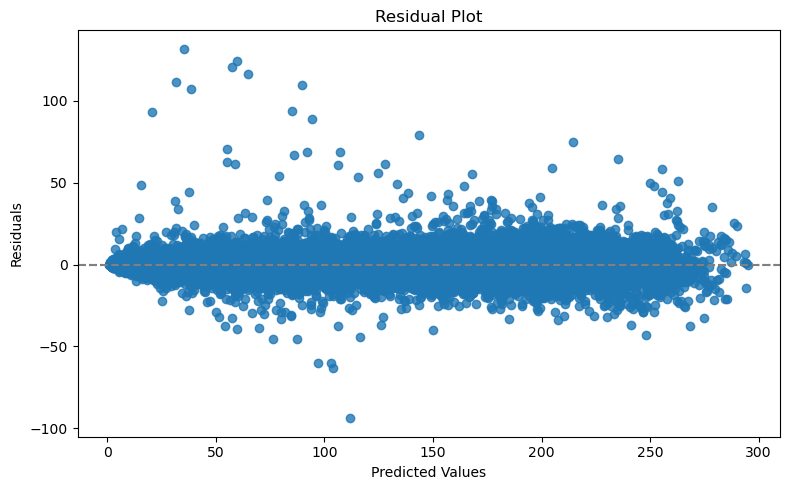

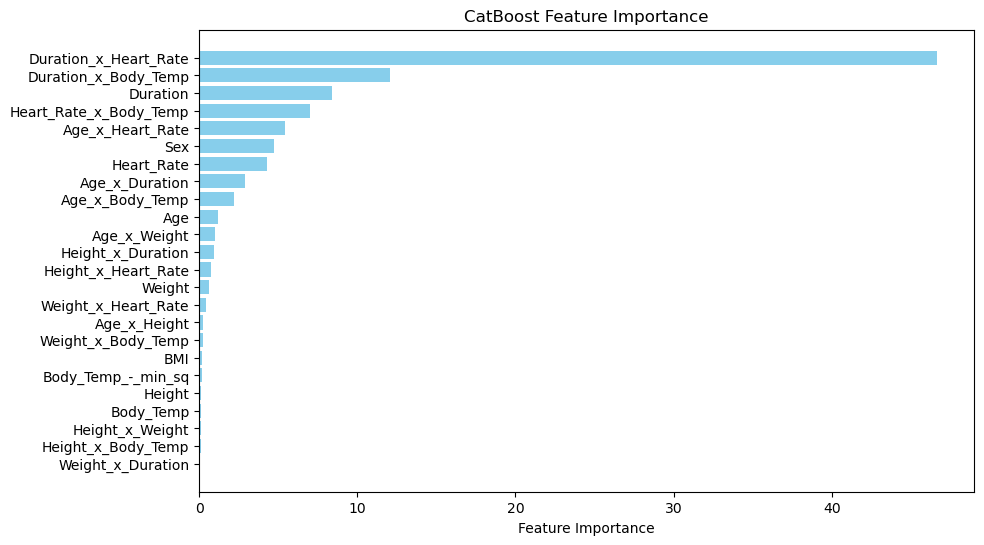

       id    Calories
0  750000   27.614723
1  750001  107.228371
2  750002   87.741710
3  750003  124.922798
4  750004   76.451107

count    250000.000000
mean         88.177603
std          62.273245
min           1.037256
25%          34.004431
50%          76.398834
75%         135.363956
max         298.926098
Name: Calories, dtype: float64


In [ ]:
# Kaggle score private 0.05903, public 0.05737 cb_prediction_13.csv

# Best trial:
#   Value: 0.05952698559201885
#   Params: 
#     depth: 12
#     learning_rate: 0.015
#     l2_leaf_reg: 0.00011954668586223026
#     bagging_temperature: 4.475008023561076e-05
#     border_count: 133
#     grow_policy: SymmetricTree


X = add_feats(train, numerical_features)
y = train['Calories']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# Define parameters
params = {
        'iterations': 2000,
        'depth': 12,
        'learning_rate': 0.015,
        'l2_leaf_reg': 0.00011954668586223026,
        'bagging_temperature': 4.475008023561076e-05,
        'border_count': 133,
        "grow_policy": "SymmetricTree",
        'task_type': 'GPU',
        'eval_metric': 'RMSE',
    }

# Initialize the model with the suggested hyperparameters
model = CatBoostRegressor(
    **params,
    loss_function='RMSE',
    random_state=724,
    verbose=0,
    early_stopping_rounds=40,
    use_best_model=True,
)

# Create pool for validation to enable early stopping
train_pool = Pool(X_train, y_train, cat_features=[0])
val_pool = Pool(X_test, y_test, cat_features=[0])

# Train and evaluate
model.fit(train_pool, eval_set=val_pool, verbose=False, use_best_model=True)
print("Stopped at:", model.get_best_iteration())


# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1
train_pred[train_pred > 320] = 300
test_pred[test_pred < 0] = 1
test_pred[test_pred > 320] = 300

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))


# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()


# make the submission file!
testsub = add_feats(test, numerical_features)

pred = model.predict(testsub)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("cb_prediction_13.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### SHAP values for explainability

Which features contribute most to the models performance?

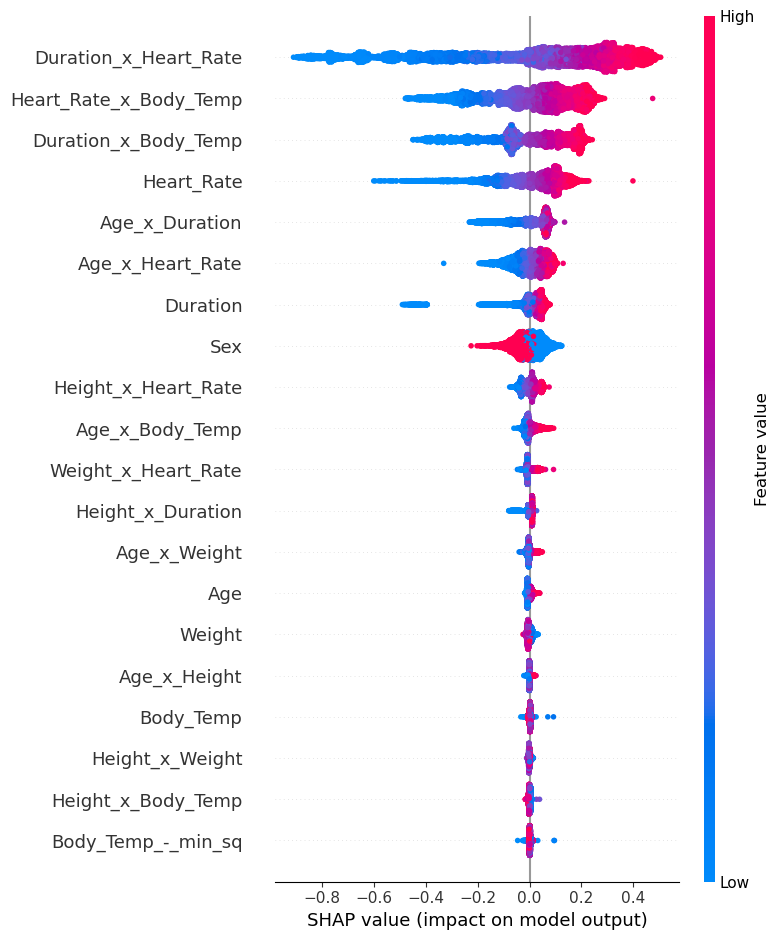

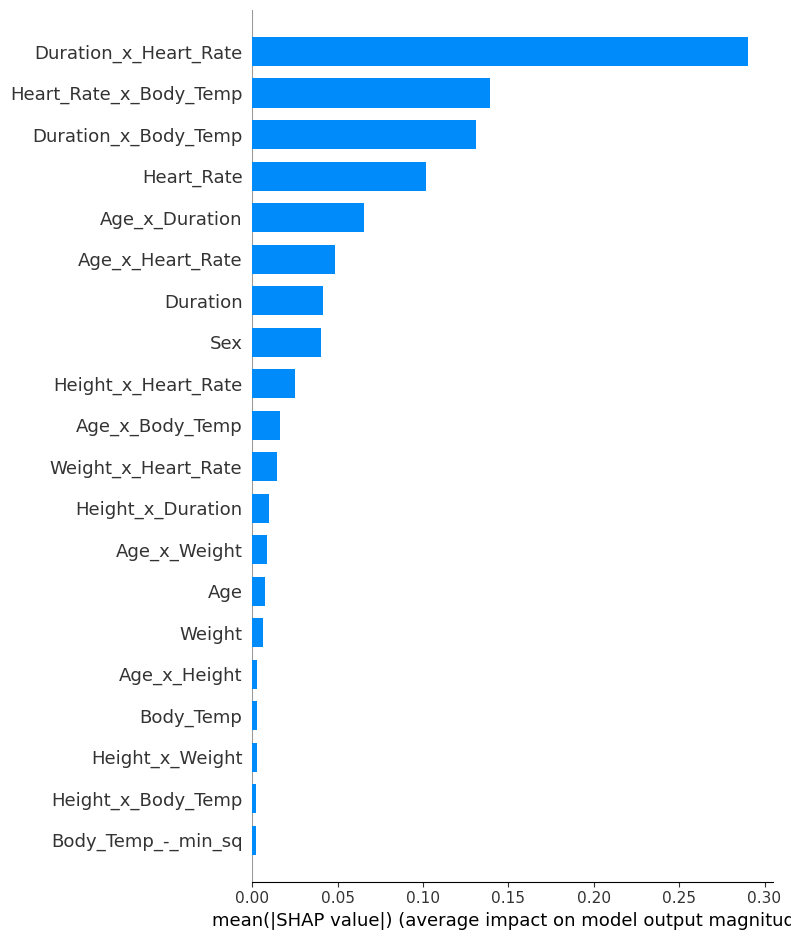

In [13]:
explainer  = shap.TreeExplainer(model)

# compute SHAP on 10000-point sample
X_small    = X_train.sample(10000, random_state=724)
shap_vals  = explainer.shap_values(X_small)

# visualize
shap.summary_plot(shap_vals, X_small)
shap.summary_plot(shap_vals, X_small, plot_type='bar')

#### SHAP Dependence plots

How are features related?

In this plot, we can see that Duration and Heart_Rate appear to be related; as Duration increases, so does Heart_Rate, and the SHAP values.

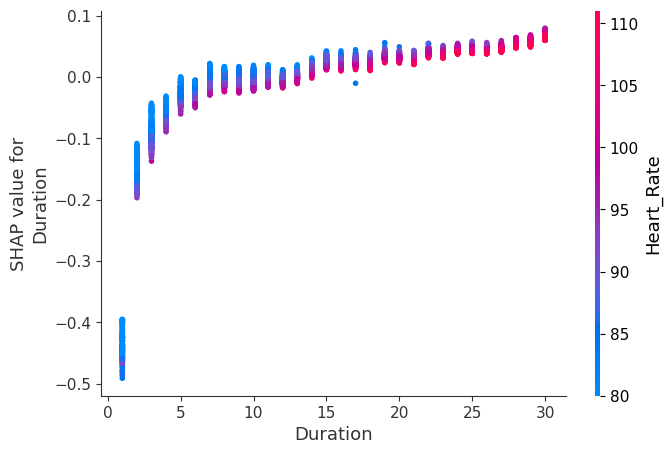

In [14]:
shap.dependence_plot(
    'Duration',
    shap_vals,
    X_small,
   interaction_index='Heart_Rate'  # name or index of the feature to color by
)

We can see the relation between Duration_x_Heart_Rate and increases SHAP values.  Moreover, it appears that Sex (red for male) and Duration_x_Heart_Rate have no relation.

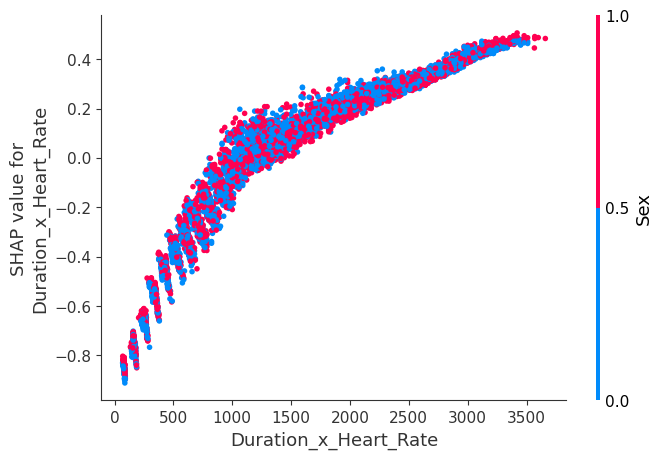

In [15]:
shap.dependence_plot(
    'Duration_x_Heart_Rate',
    shap_vals,
    X_small,
   interaction_index='Sex'  # name or index of the feature to color by
)

We can see that Age has little effect on SHAP values (notice the scale).

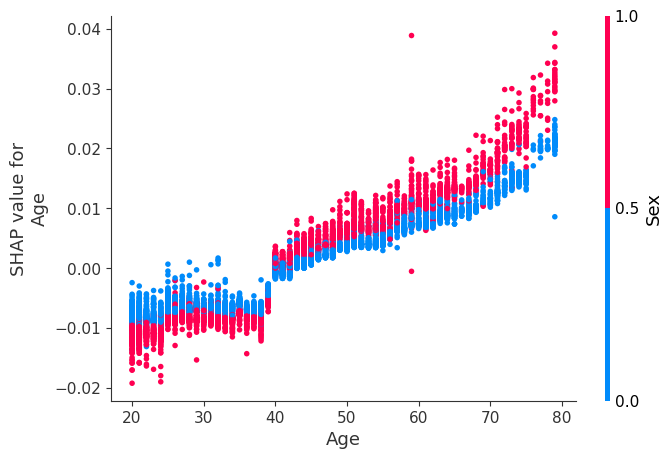

In [16]:
shap.dependence_plot(
    'Age',
    shap_vals,
    X_small,
   interaction_index='Sex'  # name or index of the feature to color by
)

#### SHAP waterfall plots

Below, $E[f(X)]$ is the mean value of the predicted log-transformed Calories and $f(x)$ is the predicted value of (log-transformed) Calories for the $i^{\mathrm{th}}$ entry of our dataset.  The red/blue arrows with a number inside represent that features impact on the difference between the mean value and predicted value.

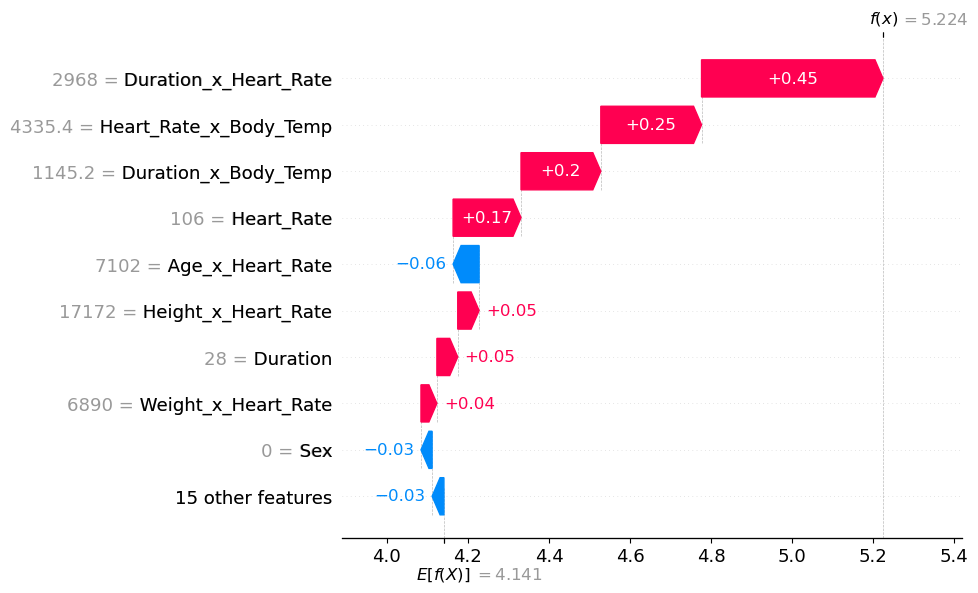

In [19]:
i = 0

shap.plots.waterfall(
    shap.Explanation(
      values=shap_vals[i], 
      base_values=explainer.expected_value, 
      data=X_test.iloc[i]
    )
)